In [1]:
# Specify the name that is used to seach for the data
place_name = "Tierkidi"


# import osmnx
import osmnx as ox
import geopandas as gpd

# Get place boundary related to the place name as a geodataframe
area = ox.geocode_to_gdf(place_name)


area

,geometry,bbox_west,bbox_south,bbox_east,bbox_north,place_id,osm_type,osm_id,lat,lon,class,type,place_rank,importance,addresstype,name,display_name
0,"POLYGON ((34.27316 8.27681, 34.27327 8.27627, ...",34.273159,8.268064,34.313275,8.284754,39494647,way,945024347,8.27654,34.291818,amenity,refugee_site,30,0.00004,amenity,Tierkidi,"Tierkidi, B50, Tharpham, Agnuak, Gambela Regio..."


<Axes: >

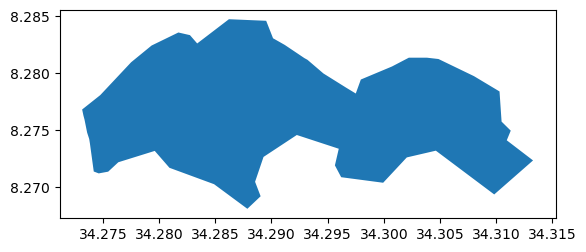

In [2]:
# Check the data type
type(area)
area.plot()


In [3]:
# List key-value pairs for tags
# Get features from OpenStreetMap (you can specify a variety of tags)

buildings = ox.features_from_place(place_name, tags={'building': 'yes'})
buildings.head()


geometry  amenity  \
element id                                                                      
way     310114743  POLYGON ((34.2846 8.27341, 34.28463 8.27338, 3...  shelter   
        310114744  POLYGON ((34.28454 8.27348, 34.28457 8.27345, ...  shelter   
        310114745  POLYGON ((34.28449 8.27352, 34.28452 8.27348, ...  shelter   
        310114746  POLYGON ((34.28463 8.27336, 34.28466 8.27333, ...  shelter   
        310114747  POLYGON ((34.28488 8.27309, 34.2849 8.27307, 3...  shelter   

                  building name  
element id                       
way     310114743      yes  NaN  
        310114744      yes  NaN  
        310114745      yes  NaN  
        310114746      yes  NaN  
        310114747      yes  NaN

<Axes: >

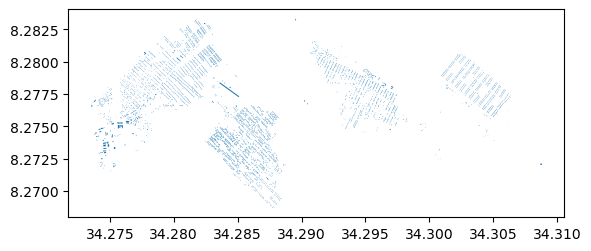

In [4]:
# Plot footprints 
buildings.plot()

In [5]:
shelters = ox.features_from_place(place_name, tags={'amenity': 'shelter'})
shelters.head()

geometry  amenity  \
element id                                                                      
way     310114743  POLYGON ((34.2846 8.27341, 34.28463 8.27338, 3...  shelter   
        310114744  POLYGON ((34.28454 8.27348, 34.28457 8.27345, ...  shelter   
        310114745  POLYGON ((34.28449 8.27352, 34.28452 8.27348, ...  shelter   
        310114746  POLYGON ((34.28463 8.27336, 34.28466 8.27333, ...  shelter   
        310114747  POLYGON ((34.28488 8.27309, 34.2849 8.27307, 3...  shelter   

                  building  
element id                  
way     310114743      yes  
        310114744      yes  
        310114745      yes  
        310114746      yes  
        310114747      yes

In [6]:
# Let's assume that buildings are demand points. 
buildings

geometry  amenity  \
element id                                                                      
way     310114743  POLYGON ((34.2846 8.27341, 34.28463 8.27338, 3...  shelter   
        310114744  POLYGON ((34.28454 8.27348, 34.28457 8.27345, ...  shelter   
        310114745  POLYGON ((34.28449 8.27352, 34.28452 8.27348, ...  shelter   
        310114746  POLYGON ((34.28463 8.27336, 34.28466 8.27333, ...  shelter   
        310114747  POLYGON ((34.28488 8.27309, 34.2849 8.27307, 3...  shelter   
...                                                              ...      ...   
        964582541  POLYGON ((34.27449 8.27344, 34.27448 8.27357, ...      NaN   
        964582543  POLYGON ((34.27596 8.27509, 34.27603 8.27509, ...      NaN   
        964582544  POLYGON ((34.27584 8.27509, 34.27594 8.27509, ...      NaN   
        964582545  POLYGON ((34.27574 8.27509, 34.27582 8.27509, ...      NaN   
        964582546  POLYGON ((34.27563 8.27509, 34.27572 8.27509, ...      NaN   

                  building name  
element id                       
way     310114743      yes  NaN  
        310114744      yes  NaN  
        310114745      yes  NaN  
        310114746      yes  NaN  
        310114747      yes  NaN  
...                    ...  ...  
        964582541      yes  NaN  
        964582543      yes  NaN  
        964582544      yes  NaN  
        964582545      yes  NaN  
        964582546      yes  NaN  

[4585 rows x 4 columns]

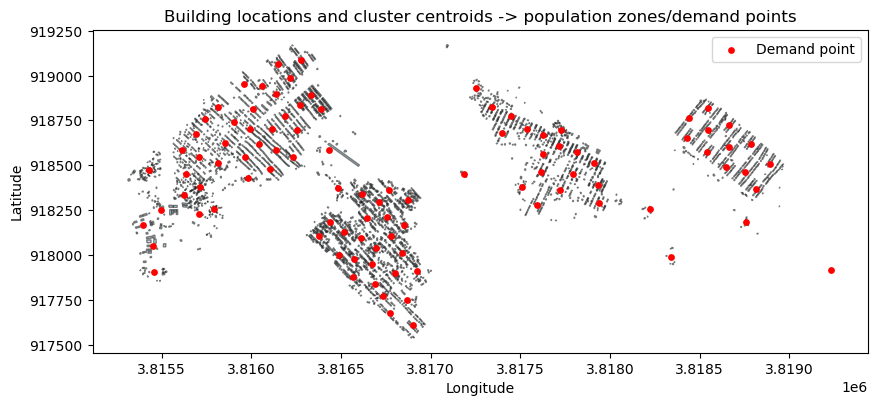

In [11]:
import geopandas as gpd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import numpy as np
import random

# Step 1: Reproject to a projected CRS (e.g., UTM)
# You can use an appropriate EPSG code for your area. Here's an example using EPSG 3395 (WGS 84 / World Mercator).
buildings_projected = buildings.to_crs(epsg=3395)  # Reproject to projected CRS (e.g., meters)

# Step 2: Calculate centroids in the projected CRS
buildings_projected['centroid'] = buildings_projected.geometry.centroid

# Step 3: Extract centroids' coordinates (X and Y)
centroid_coords = buildings_projected['centroid'].apply(lambda geom: (geom.x, geom.y))

# Step 4: Perform KMeans clustering to divide the area into 100 population zones
random.seed(42)  # Python's built-in random module
np.random.seed(42)  # NumPy's random module

kmeans = KMeans(n_clusters=100, random_state=42)
buildings_projected['cluster'] = kmeans.fit_predict(centroid_coords.tolist())


# Step 5: Plot the buildings and cluster centroids
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buildings
buildings_projected.plot(ax=ax, color="lightblue", alpha=0.5, edgecolor="black")

# Plot the cluster centroids (directly from kmeans cluster centers)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            color="red", marker="o", s=15, label="Demand point")

# Set title and labels
plt.title("Building locations and cluster centroids -> population zones/demand points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.show()


In [13]:
import random
import numpy as np

# Assume kmeans.cluster_centers_ is a numpy.ndarray with the centroids

random.seed(42)  # Python's built-in random module
np.random.seed(42)  # NumPy's random module

# Step 1: Randomly select 10 points as HPs
hp_indices = random.sample(range(len(kmeans.cluster_centers_)), 10)  # Randomly select 5 indices
hp_centroids = kmeans.cluster_centers_[hp_indices]  # HP centroids based on selected indices

# Step 2: Randomly select 2 of the selected 10 HP points as candidate locations for HCs
hc_candidate_indices = random.sample(hp_indices, 2)  # Randomly select 2 indices from the HP points
hc_candidates = kmeans.cluster_centers_[hc_candidate_indices]  # HC candidate points from selected HPs

# Step 3: Randomly select 5 additional points as HCs, excluding those already selected
remaining_indices = list(set(range(len(kmeans.cluster_centers_))) - set(hp_indices) - set(hc_candidate_indices))  # Indices not in HPs or HC candidates
hc_indices = random.sample(remaining_indices, 5)  # Randomly select 5 new indices
additional_hc_centroids = kmeans.cluster_centers_[hc_indices]  # HC centroids based on the new indices

# Step 4: Combine hc_candidates with additional_hc_centroids to form the final hc_centroids
hc_centroids = np.concatenate((hc_candidates, additional_hc_centroids), axis=0)




In [20]:
import geopandas as gpd
from shapely.geometry import Point

# First, let's create a GeoDataFrame with the centroids for demand_points
gdf_demand = gpd.GeoDataFrame(
    geometry=[Point(x, y) for x, y in kmeans.cluster_centers_],
    crs="EPSG:3395"  # Example: assuming the current CRS is EPSG:3395 (Mercator / meters)
)

# Reproject the points to EPSG:4326 (lat/lon)
gdf_demand = gdf_demand.to_crs("EPSG:4326")

# Extract lat/lon from the GeoDataFrame
demand_centroids_latlon = gdf_demand.geometry.apply(lambda point: [point.x, point.y]).tolist()
demand_centroids_latlon


# First, let's create a GeoDataFrame with the centroids for HPs
gdf_hp = gpd.GeoDataFrame(
    geometry=[Point(x, y) for x, y in hp_centroids],
    crs="EPSG:3395"  # Example: assuming the current CRS is EPSG:3395 (Mercator / meters)
)

# Reproject the points to EPSG:4326 (lat/lon)
gdf_hp = gdf_hp.to_crs("EPSG:4326")

# Extract lat/lon from the GeoDataFrame
hp_centroids_latlon = gdf_hp.geometry.apply(lambda point: [point.x, point.y]).tolist()
hp_centroids_latlon


# First, let's create a GeoDataFrame with the centroids for HCs
gdf_hc = gpd.GeoDataFrame(
    geometry=[Point(x, y) for x, y in hc_centroids],
    crs="EPSG:3395"  # Example: assuming the current CRS is EPSG:3395 (Mercator / meters)
)

# Reproject the points to EPSG:4326 (lat/lon)
gdf_hc = gdf_hc.to_crs("EPSG:4326")

# Extract lat/lon from the GeoDataFrame
hc_centroids_latlon = gdf_hc.geometry.apply(lambda point: [point.x, point.y]).tolist()
hc_centroids_latlon

[[34.27430260694197, 8.274329322641789],
 [34.29517720488452, 8.27608329261814],
 [34.281407966864364, 8.279740812574703],
 [34.285955575535674, 8.273197766346472],
 [34.29226366927366, 8.278898902690374],
 [34.278022774168775, 8.277414584560066],
 [34.305698731581074, 8.277353954069552]]

In [47]:
import geopandas as gpd
from shapely.geometry import Point
import random

# Sample data (replace with your kmeans.centroids)
# kmeans.cluster_centers_ contains the coordinates of centroids
demand_centroids = demand_centroids_latlon

# Initialize a list to store the features
features = []

# Generate features for each demand point
for i, centroid in enumerate(demand_centroids_latlon):
    feature = {
        "type": "Feature",
        "properties": {
            "Name": f"Tierkidi{i+1}", 
            "Camp": "Tierkidi", 
            "type_f": "demand_point",
            "id": f"dp{i+1}" 
        },
        "geometry": {
            "type": "Point",
            "coordinates": [centroid[0], centroid[1]]  # Longitude, Latitude
        }
    }
    features.append(feature)



# Create HP features
for i, hp in enumerate(hp_centroids_latlon):
    feature = {
        "type": "Feature",
        "properties": {
            "Name": f"HP_CandidateLocation{i+1}",
            "Camp": "Tierkidi",
            "type_f": "HP",
            "id": f"hp{i+1}"
        },
        "geometry": {
            "type": "Point",
            "coordinates": [hp[0], hp[1]]  # Longitude, Latitude
        }
    }
    features.append(feature)

# Create HC features
for i, hc in enumerate(hc_centroids_latlon):
    feature = {
        "type": "Feature",
        "properties": {
            "Name": f"HC_CandidateLocation{i+1}",
            "Camp": "Tierkidi",
            "type_f": "HC",
            "id": f"hc{i+1}"
        },
        "geometry": {
            "type": "Point",
            "coordinates": [hc[0], hc[1]]  # Longitude, Latitude
        }
    }
    features.append(feature)



# Create the final GeoJSON structure
geojson = {
    "type": "FeatureCollection",
    "name": "location_tierkidi",
    "features": features
}

# To save the geojson file
import json
with open("tierkidi_baseline.geojson", "w") as f:
    json.dump(geojson, f)

print("GeoJSON file created: tierkidi_baseline.geojson")


GeoJSON file created: tierkidi_baseline.geojson


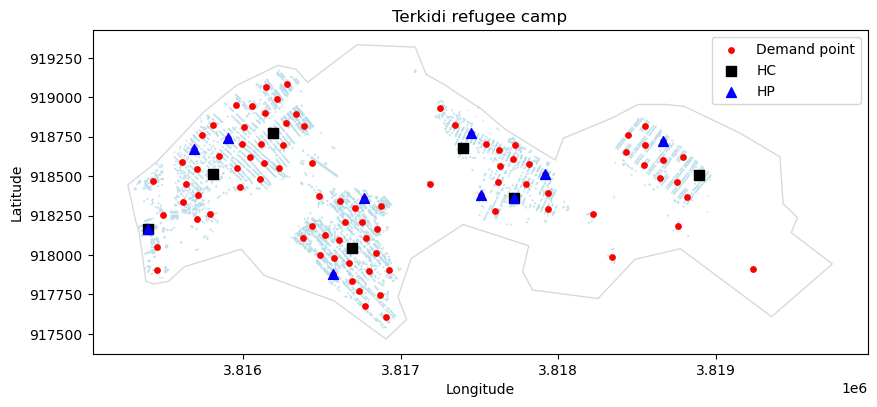

In [ ]:

# Plot the buildings and cluster centroids for demand points, candidate locations of HPs and candidate locations of HCs
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the buildings
buildings_projected.plot(ax=ax, color="lightblue", alpha=0.6, edgecolor="lightblue")

# Plot the cluster centroids (directly from kmeans cluster centers)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            color="red", marker="o", s=15, label="Demand point")


# Plot the hc_centroids with black squares
plt.scatter(hc_centroids[:, 0], hc_centroids[:, 1], 
            color="black", marker="s", s=50, label="HC")

# Plot the hp_centroids with blue triangles
plt.scatter(hp_centroids[:, 0], hp_centroids[:, 1], 
            color="blue", marker="^", s=50, label="HP")

if area.crs != buildings_projected.crs:
    area = area.to_crs(buildings_projected.crs)

# Plot the boundary of the area (outline only)
area.plot(ax=ax, edgecolor="gray", alpha=0.3, linewidth=1, facecolor="none")

# Set title and labels
plt.title("Terkidi refugee camp")

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
#plt.savefig("terkidi.png", dpi=300, bbox_inches="tight")
plt.show()

In [37]:
print(area.crs)
print(buildings_projected.crs)

epsg:4326
EPSG:3395
